In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main')

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (
    LinearRegression,
    PoissonRegressor,
    GammaRegressor,
    HuberRegressor,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Import datasets
from doubt.datasets import (
    Airfoil,
    Blog,
    Concrete,
    CPU,
    FacebookComments,
    FishBioconcentration,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
    SpaceShuttle,
    Yacht,
)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt

plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from collections import defaultdict
import seaborn as sns

sns.set_theme(style="whitegrid")
import shap

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [3]:
ls data

LICENSE.md   dev_in.csv   dev_out.csv  train.csv


In [4]:
train = pd.read_csv("data/train.csv", nrows=10_000)
test = pd.read_csv("data/dev_out.csv", nrows=10_000)

In [5]:
cols = [
    "fact_time",
    "fact_latitude",
    "fact_longitude",
    "fact_temperature",
    "fact_cwsm_class",
    "climate",
    "cmc_timedelta_s",
]

In [6]:
X_tr = train.drop(columns=cols).fillna(-1)
y_tr = train.fact_temperature

X_te = test.drop(columns=cols).fillna(-1)
y_te = test.fact_temperature

In [7]:
standard_scaler = StandardScaler()

# Scale the dataset
standard_scaler.fit(X_tr)

X_tr = pd.DataFrame(standard_scaler.transform(X_tr), columns=X_tr.columns)
X_te = pd.DataFrame(standard_scaler.transform(X_te), columns=X_te.columns)

# Fit the regressor
# regressor = Boot(XGBRegressor(max_depth=5, n_estimators=50))
regressor = Boot(LinearRegression())

regressor.fit(X_tr, y_tr, n_boots=20)

Boot(model=LinearRegression, random_seed=None)

In [8]:
# Train preds
predictions, intervals = regressor.predict(X_tr, uncertainty=0.05)

In [9]:
values = {}
values["uncertainty_train"] = intervals[:, 1] - intervals[:, 0]
values["mse_train"] = (predictions - y_tr) ** 2

In [10]:
# Test preds
predictions, intervals = regressor.predict(X_te, uncertainty=0.05)
values["uncertainty_test"] = intervals[:, 1] - intervals[:, 0]
values["mse_test"] = (predictions - y_te) ** 2


d = pd.DataFrame(values)

In [11]:
d = d.reindex(sorted(d.columns), axis=1)

d.describe()

,mse_test,mse_train,uncertainty_test,uncertainty_train
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.669836e+21,4.925855e+00,5.623417e+11,3.098907e+09
std,1.947346e+22,1.043235e+01,7.765308e+12,1.824690e+11
min,1.578480e-08,1.112480e-07,8.897028e+00,8.903163e+00
25%,4.029902e-01,3.379814e-01,8.938581e+00,8.931315e+00
50%,1.864198e+00,1.612916e+00,8.958498e+00,8.947951e+00
75%,5.941024e+00,5.276611e+00,8.992612e+00,8.975079e+00
max,2.287447e+23,2.332079e+02,1.267185e+14,1.226064e+13


In [12]:
# Scaling the results
sc = StandardScaler()
sc.fit(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_train"] = sc.transform(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_test"] = sc.transform(d["uncertainty_test"].values.reshape(-1, 1))

sc = StandardScaler()
sc.fit(d["mse_train"].values.reshape(-1, 1))
d["mse_train"] = sc.transform(d["mse_train"].values.reshape(-1, 1))
d["mse_test"] = sc.transform(d["mse_test"].values.reshape(-1, 1))

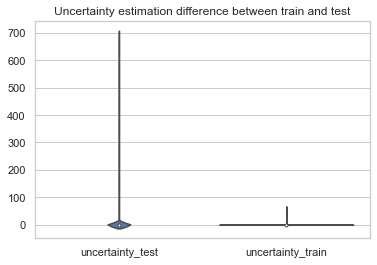

In [13]:
plt.figure()
sns.violinplot(data=d.drop(columns=["mse_train", "mse_test"]))
plt.title('Uncertainty estimation difference between train and test')
plt.show()

<AxesSubplot:>

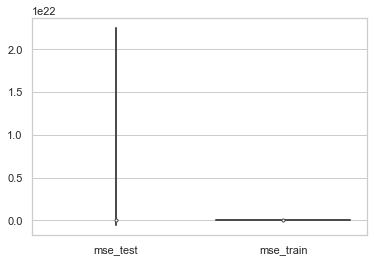

In [14]:
sns.violinplot(data=d.drop(columns=["uncertainty_train", "uncertainty_test"]))

## Detecting the source of uncertainty

In [15]:
reg = XGBRegressor()
reg.fit(X_te, d["uncertainty_test"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
mean_squared_error(reg.predict(X_te), d["uncertainty_test"])

1.691198082518158e-10

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


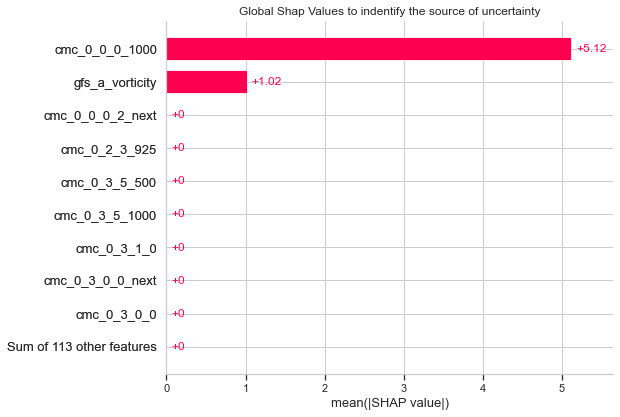

In [17]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_te)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
plt.figure()
plt.title("Global Shap Values to indentify the source of uncertainty")
shap.plots.bar(shap_values, show=False)
plt.savefig("experiments/xai/shap.png")
plt.show()

divide by zero encountered in double_scalars


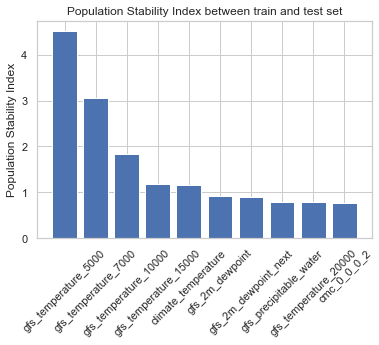

In [18]:
psi_dic = []
for c in X_tr.columns:
    psi_dic.append([c, psi(X_tr[c], X_te[c]),ks_2samp(X_tr[c], X_te[c]).statistic])



psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi",'ks'])


plt.figure()
plt.title('Population Stability Index between train and test set')
plt.ylabel('Population Stability Index')
keys = psi_dic.sort_values("psi", ascending=False).head(10).column.values
values = psi_dic.sort_values("psi", ascending=False).head(10).psi.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.savefig('experiments/xai/psi.png')
plt.show()



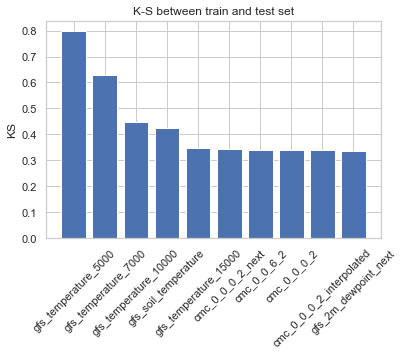

In [19]:
plt.figure()
plt.title('K-S between train and test set')
plt.ylabel('KS')
keys = psi_dic.sort_values("ks", ascending=False).head(10).column.values
values = psi_dic.sort_values("ks", ascending=False).head(10).ks.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.show()

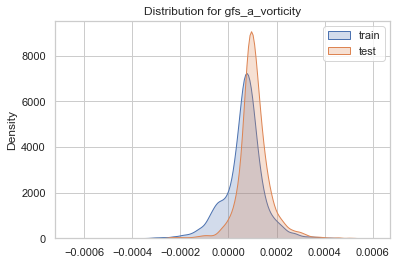

In [20]:
feat = 'gfs_a_vorticity'
plt.figure()
plt.title('Distribution for {}'.format(feat))
sns.kdeplot(train[feat].values, fill=True,label='train')
sns.kdeplot(test[feat].values,fill=True,label='test')
plt.legend()
plt.show()